# Άσκηση 3 - Ομάδα Β17
# Λαμπρινίδης-Λέντελ Βλαντισλάβ, 03114054
# Μαρμάνης Ιάσων, 03114088

In [ ]:
! pip install deap
! pip install tabulate
! pip install dill

In [ ]:
from math import cos, sin, pi
from deap import base, creator, tools, algorithms
import multiprocessing, random
import numpy as np
import statistics as st
from tabulate import tabulate
from timeit import default_timer as timer
import operator
from IPython.display import HTML, display
from sklearn.externals import joblib  

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)

Υλοποιούμε, παρακάτω, λίστες με όλους τους **τελεστές** που θα χρησιμοποιήσουμε κατά την εκτέλεση των γενετικών αλγορίθμων. Ταυτόχρονα, εισάγουμε και τις παραμέτρους που θα απαιτήσει ο κάθε αλγόριθμος, για τη δική μας ευκολία.

In [80]:
mates = [("UniformCrossoverLow", ("mate", tools.cxUniform), {'indpb' : 0.3}), 
         ("UniformCrossoverHigh", ("mate", tools.cxUniform), {'indpb' : 0.6}), 
         ("BlendCrossoverLow", ("mate", tools.cxBlend), {'alpha' : 0.3}), 
         ("BlendCrossoverHigh", ("mate", tools.cxBlend), {'alpha' : 0.6})]

mutates = [("GaussianMutationLow", ("mutate", tools.mutGaussian), {'mu' : 0.0, 'sigma' : 1.0, 'indpb' : 0.3}),
           ("GaussianMutationHigh", ("mutate", tools.mutGaussian), {'mu' : 0.0, 'sigma' : 1.0, 'indpb' : 0.6}),
           ("mutShuffleIndexesLow", ("mutate", tools.mutShuffleIndexes), {'indpb': 0.3}),
           ("mutShuffleIndexesHigh", ("mutate", tools.mutShuffleIndexes), {'indpb': 0.6})]

selects = [("SelectionTournamentLow", ("select", tools.selTournament), {'tournsize' : 3}),
           ("SelectionTournamentHigh", ("select", tools.selTournament), {'tournsize' : 6})]

Η λίστα algs περιλαμβάνει τον **απλό** καθώς και τους __μ, λ__ αλγορίθμους.

In [81]:
algs = [("Simple", algorithms.eaSimple),
        ("Plus", algorithms.eaMuPlusLambda),
        ("Comma", algorithms.eaMuCommaLambda)]

Δημιουργούμε και ένα **λεξικό** το οποίο χρησιμοποιούμε για να έχουμε πιο εύκολη πρόσβαση στους επιθυμητούς τελεστές και στον επιθυμητό αλγόριθμο.

In [82]:
mate_ = {'UniLow': mates[0], 'UniHigh': mates[1], 'BlendLow': mates[2], 'BlendHigh': mates[3]}
mutate_ = {'GaussLow': mutates[0], 'GaussHigh': mutates[1], 'ShufLow': mutates[2], 'ShufHigh': mutates[3]}
select_ = {'Low': selects[0], 'High': selects[1]}
alg_ = {'Simple': algs[0], 'Plus': algs[1], 'Comma': algs[2]}

Παρακάτω υλοποιούμε συναρτήσεις που θα χρησιμοποιήσουμε τόσο για το __μέρος 1__ όσο και για το __μέρος 2__ της άσκησης.
Η συνάρτηση `setbox` λαμβάνει ως παραμέτρους ένα στιγμιότυπο της κλάσης **Toolbox**, στο οποίο και αναθέτει τις υπόλοιπες παραμέτρους εισόδου, δηλαδή τη συνάρτηση αποτίμησης, την ποινή, τον τύπο των μεταβλητών εισόδου αλλά και τα όριά τους, ενώ παράλληλα ορίζει τη διάσταση της συνάρτησης, το άτομο και τον πληθυσμό.

In [85]:
def setbox(toolbox, evalfunc, feasible, distance, penalty=300, fmin=-100, fmax=100, fdim=2):
    toolbox.register("help", lambda : {'penalty': penalty, 'dim': fdim})
    
    toolbox.register("evaluate", evalfunc)
    toolbox.decorate("evaluate", tools.DeltaPenality(feasible, penalty, distance))

    toolbox.register("attr_int", random.randint, fmin, fmax)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, fdim)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

Η συνάρτηση `compute` εκτελεί το πιο σημαντικό έργο της παρούσας άσκησης. Πιο συγκεκριμένα, λαμβάνει ως όρισμα ένα στιγμιότυπο **toolbox**, που έχει αρχικοποιηθεί με την `setbox`, καθώς και ένα τελεστή από κάθε κατηγορία (Διασταύρωση, Μετάλλαξη και Επιλογή) και εκτελεί τον επιθυμητό γενετικό αλγόριθμο, επιστρέφοντας τις μετρικές που έχουν οριστεί στην εκφώνηση της άσκησης, με τη μορφή **τούπλας**. Επιπλέον παράμετροι εισόδου είναι το πλήθος των *γύρων*, των *γενεών* και του *πληθυσμού*, οι παράμετροι __μ, λ__ για τους **Plus** και **Comma** αλγορίθμους, καθώς και η παράμετρος **Δέλτα** που ζητείται από την άσκηση, όλες εκ των οποίων έχουν προκαθορισμένες μικρές και λογικές τιμές, με σκοπό την ταχύτερη εκτέλεση.

In [ ]:
def compute(toolbox, ops, alg, mu=100, lambda_=100, cxpb=0.5, mutpb=0.2, GOAL=0, DELTA=10**(-4),
            max_rounds=10, max_gens=150, population=100): # ops is a list with one of each of the 3 operators
    for _, x, y in ops:
        toolbox.register(*x, **y)
    titles = [op[0] for op in ops]
    alg_title = alg[0]
    
    info = toolbox.help()
    dimension = info['dim']
    penalty = info['penalty']
    
    avg_min = 0 
    avg_evals = 0
    avg_time = 0
    
    successes = 0
    success_avg_gen = 0
    success_avg_min = 0
    success_avg_evals = 0
        
    for i in range(max_rounds):
        pop = toolbox.population(n=population)
        
        if(alg[0]=="Plus" or alg[0]=="Comma"):
            params = {'mu' : mu, 'lambda_' : lambda_}
        else:
            params = {}
            
        start = timer()
        _, logbook = alg[1](pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=max_gens, stats = stats, verbose=False, **params)
        end = timer()
        
        min_ls = logbook.select("min")
        avg_ls = logbook.select("avg")
        
        avg_min += min ( min_ls )
        avg_evals += st.mean ( avg_ls )
        avg_time += (end - start)
        
        gen_ls = [i for i, elem in enumerate(min_ls) if abs(elem)<GOAL+DELTA]
        if(not not gen_ls): # if list not empty
            successes += 1
            success_avg_gen += (gen_ls[0]+1) # because counting starts from zero
            success_avg_min += min_ls[gen_ls[0]]
            success_avg_evals += st.mean( [avg_ls[i] for i in range(0,gen_ls[0]+1)] )
        
    avg_min /= max_rounds
    avg_evals /= max_rounds
    avg_time /= max_rounds
    
    def comp(avg):
        return None if (successes <= 0) else avg/successes

    success_avg_gen = comp(success_avg_gen)
    success_avg_min = comp(success_avg_min)
    success_avg_evals = comp(success_avg_evals)
            
    return ( ", ".join(titles), alg_title, avg_min, avg_evals, avg_time, 
            successes, success_avg_gen, success_avg_min, success_avg_evals, cxpb, mutpb, dimension, penalty, mu, lambda_ )

Η `sort_print` αναλαμβάνει να ταξινομήσει μια λίστα από τις εκτελέσεις που προκύπτουν από την `compute` αλλά και να εκτυπώσει σε **HTML** πίνακα τα αποτελέσματα. Τα ορίσματα της συνάρτησης σηματοδοτούν αφενός την μετρική με βάση την οποία θα γίνει η ταξινόμηση και αφετέρου τις μετρικές που θα εμφανιστούν στον πίνακα.

In [87]:
def sort_print(ls, min_=True, evals=True, probs = False, succ = False, succ_avg_gen = False,
               succ_avg_min = False, succ_avg_evals = False, dim = False, mu_lambda=False):
     # Sort input list
    ls.sort(key = operator.itemgetter(4)) # sort by avg.time
    ls.sort(key = operator.itemgetter(2)) # sort by avg.min
    if(succ_avg_min):
        not_zero = [elem for elem in ls if elem[5]>0]
        zero = [elem for elem in ls if elem[5]<=0]
        not_zero.sort(key = operator.itemgetter(7)) # sort by success avg.min
        ls.clear()
        ls.extend(not_zero + zero)
    if(succ_avg_gen):
        not_zero = [elem for elem in ls if elem[5]>0]
        zero = [elem for elem in ls if elem[5]<=0]
        not_zero.sort(key = operator.itemgetter(6)) # sort by success avg.gen
        ls.clear()
        ls.extend(not_zero + zero)
    if(succ):
        ls.sort(key = operator.itemgetter(5), reverse=True) # sort by successes
        
    # Print requested elements
    _ls = [elem[:2] for elem in ls ]
    hd = ['operators','strategy']
    if min_:
        _ls = [ x + (y[2],) for x,y in zip(_ls,ls) ]
        hd += ['avg.min']
    if evals:
        _ls = [ x + (y[3],) for x,y in zip(_ls,ls) ]
        hd += ['avg.evals']
    _ls = [ x + (y[4],) for x,y in zip(_ls,ls) ]
    hd += ['avg.time']
    if succ:
        _ls = [ x + (y[5],) for x,y in zip(_ls,ls) ]
        hd += ['successes']
    if succ_avg_gen:
        _ls = [ x + (y[6],) for x,y in zip(_ls,ls) ]
        hd += ['success avg.gen']
    if succ_avg_min:
        _ls = [ x + (y[7],) for x,y in zip(_ls,ls) ]
        hd += ['success avg.min'] 
    if succ_avg_evals:
        _ls = [ x + (y[8],) for x,y in zip(_ls,ls) ]
        hd += ['success avg.evals']
    if probs:
        _ls = [ x + y[9:11] for x,y in zip(_ls,ls) ]
        hd += ['cxpb', 'mutpb']
    if dim:
        _ls = [ x + y[11:13] for x,y in zip(_ls,ls) ]
        hd += ['Dimension', 'Penalty']
    if mu_lambda:
        _ls = [ x + y[13:] for x,y in zip(_ls,ls) ]
        hd += ['Mu', 'Lambda']
    display(HTML(tabulate(_ls, headers = hd, tablefmt='html' )))

Η `combination_search` εκτελεί ουσιαστικά το ζητούμενο __grid search__, με τη βοήθεια της `compute`, για όλους τους συνδυασμούς και επιστρέφει μια λίστα με όλα τα αποτελέσματα, τα οποία αποτελούν **tuples**. Ως όρισμα λαμβάνει μονάχα το **Δέλτα**, πέρα από το στιγμιότυπο **toolbox**.

In [88]:
def combination_search(toolbox, DELTA=10**(-4)):
    return [compute(toolbox, [mate,mutate,select], alg, 
                    DELTA=DELTA) for mate in mates for mutate in mutates for select in selects for alg in algs]

Τέλος, η `prob_search` εκτελεί grid search στα διαστήματα πιθανοτήτων που δίνουμε ως παράμετρο. 

In [89]:
def prob_search(toolbox, ops, alg, interval1, interval2, DELTA=10**(-4), prob_cons=False):
    return [compute(toolbox, ops, alg, cxpb=cxpb, mutpb=mutpb, DELTA=DELTA) for cxpb in interval1 for mutpb in interval2
           if not prob_cons or cxpb+mutpb<=1]

# Μέρος 1

Ορίζουμε παρακάτω τη συνάρτηση $Boha \ 2$ (που έχει ανατεθεί στην ομάδα μας προς ελαχιστοποίηση):

$$f(x_1,x_2) = x_1^2 + 2x_2^2 - 0.3cos(3πx_1)cos(4πx_2) + 0.3$$

με τον περιορισμό $x_i \in [-100,100], \forall i$
και ολικό ελάχιστο στο $(x_1,x_2) = (0,0)$ με τιμή $f(0,0)=0$

In [11]:
F_MIN = -100
F_MAX = 100

def boha2(x):
    x1, x2 = x
    return x1**2 + 2*x2**2 - 0.3*cos(3*pi*x1)*cos(4*pi*x2) + 0.3,

def feasible(x):
    return all(F_MIN <= i <= F_MAX for i in x)

def distance(x):
    dist = 0
    for xi in x:
        dist += max(0, xi - F_MAX)
        dist += max(0, F_MIN - xi)
    return dist

Δημιουργούμε ένα toolbox και το αρχικοποιούμε με την **Evaluation** συνάρτηση, που είναι η `Boha 2`, καθώς και με τις **Feasible** και **Distance**. Ύστερα, παρουσιάζουμε τις εκτελέσεις με τα κατάλληλα ονόματα προκειμένου να βρούμε μία κατάλληλη τιμή για το **Δέλτα**. Σημειώνουμε πως το πλήθος των γύρων θα είναι 10, το πλήθος γενεών 150 και ο πληθυσμός 100.

In [12]:
toolbox = base.Toolbox()
setbox(toolbox, boha2, feasible, distance)

In [ ]:
res_nodelta = combination_search(toolbox)

In [12]:
sort_print(res_nodelta)

operators,strategy,avg.min,avg.evals,avg.time
"BlendCrossoverLow, mutShuffleIndexesLow, SelectionTournamentLow",Simple,0,110.452,0.42152
"BlendCrossoverHigh, mutShuffleIndexesHigh, SelectionTournamentLow",Simple,0,124.517,0.426325
"BlendCrossoverHigh, GaussianMutationLow, SelectionTournamentLow",Simple,0,125.031,0.428687
"BlendCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentLow",Simple,0,112.9,0.431485
"BlendCrossoverHigh, GaussianMutationHigh, SelectionTournamentLow",Simple,0,117.424,0.434433
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,95.1029,0.483774
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentLow",Comma,0,105.645,0.557238
"BlendCrossoverLow, mutShuffleIndexesLow, SelectionTournamentLow",Comma,0,107.012,0.558019
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentLow",Plus,0,105.158,0.561092
"BlendCrossoverHigh, mutShuffleIndexesHigh, SelectionTournamentLow",Comma,0,103.547,0.564632


Παρατηρούμε ότι σε αρκετές εκτελέσεις οι αλγόριθμοι κατάφεραν να δώσουν ελάχιστη τιμή μέχρι και 0, που είναι και ο στόχος μας. Προκειμένου να έχουμε περισσότερες επιτυχίες σε συνδυασμούς που έδωσαν τιμή πολύ κοντά στο 0, επιλέγουμε ακρίβεια 11 δεκαδικών ψηφίων για το **Δέλτα**, καθώς παρατηρούμε ότι τα πρώτα μη μηδενικά ελάχιστα εμφανίζουν αυτής της τάξης αριθμούς. Εκτελούμε λοιπόν την ίδια διαδικασία, θέτοντας ίδιους με προηγουμένως αριθμούς στις παραμέτρους (εκτός από το Δέλτα), και παρουσιάζουμε τα νέα αποτελέσματα μαζί με τις νέες μετρικές.

In [14]:
res_delta = combination_search(toolbox, DELTA=10**(-11))

In [34]:
sort_print(res_delta, succ = True, succ_avg_gen = True, succ_avg_min=True, succ_avg_evals=True)

operators,strategy,avg.min,avg.evals,avg.time,successes,success avg.gen,success avg.min,success avg.evals
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,93.5805,0.490734,10,27,5.28999e-12,527.753
"BlendCrossoverHigh, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,97.2988,0.495442,10,27.6,3.09988e-12,535.176
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Plus,0,83.1564,0.628492,10,31.3,6.33789e-12,409.994
"BlendCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentLow",Simple,0,111.25,0.430571,10,33.3,3.52397e-12,507.118
"BlendCrossoverLow, mutShuffleIndexesLow, SelectionTournamentLow",Simple,0,120.44,0.426444,10,34,4.20317e-12,545.455
"BlendCrossoverHigh, mutShuffleIndexesHigh, SelectionTournamentLow",Simple,0,127.586,0.430296,10,36.7,3.64208e-12,529.022
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentLow",Simple,0,129.192,0.423053,10,37.7,6.46951e-12,517.606
"BlendCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentLow",Comma,0,106.266,0.568489,10,39.6,5.47431e-12,409.657
"BlendCrossoverHigh, GaussianMutationLow, SelectionTournamentLow",Simple,0,133.073,0.455882,10,39.9,3.11803e-12,503.928
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentLow",Comma,0,103.782,0.562981,10,42.5,2.03036e-12,373.815


Η ταξινόμηση του παραπάνω πίνακα έγινε ως προς την μετρική *success avg.gen*, καθώς επιθυμητό κριτήριο είναι σε λιγότερες γενιές να βρούμε την τιμή που να ικανοποιεί την δοσμένη συνθήκη. Επιπλέον, έχουμε ομαδοποιήσει τα δεδομένα σε φθίνουσα σειρά ως προς τον αριθμό επιτυχιών διότι ενδιαφέρουν οι συνδυασμοί που είχαν τις περισσότερες. Παρατηρούμε, λοιπόν, ότι ο συνδυασμός με τις περισσότερες επιτυχίες (10) και τον μικρότερο αριθμό γενεών (27) στις οποίες βρήκαν το ελάχιστο έιναι η **"high"** διασταύρωση τύπου **Blend** , **"low"** μετάλλαξη τύπου __shuffle indexes__, **"high"** επιλογή **tournament** και **απλός** αλγόριθμος. Συνεχίζουμε, λοιπόν, με αυτό το συνδυασμό την αναζήτηση των βέλτιστων πιθανοτήτων για διασταύρωση και μετάλλαξη.

In [36]:
best_ops = [mate_['BlendHigh'], mutate_['ShufLow'], select_['High']]
best_alg = alg_['Simple']

In [39]:
interval1 = np.arange(0.05, 1.0, 0.05)
interval2 = np.arange(0.05, 1.0, 0.05)
res_probs = prob_search(toolbox, best_ops, best_alg, interval1,interval2, DELTA=10**(-11))

In [40]:
sort_print(res_probs, probs=True, succ = True, succ_avg_gen = True, succ_avg_min=True, succ_avg_evals=True)

operators,strategy,avg.min,avg.evals,avg.time,successes,success avg.gen,success avg.min,success avg.evals,cxpb,mutpb
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.1882,0.535374,10,20.6,3.20605e-12,53.4192,0.85,0.7
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.29703,0.53369,10,20.7,3.93696e-12,81.6141,0.65,0.8
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.28486,0.539167,10,20.9,4.17352e-12,81.2772,0.65,0.9
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.47851,0.550291,10,21,4.14594e-12,54.2359,0.95,0.8
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.33541,0.547075,10,21,4.15916e-12,53.1661,0.95,0.9
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.77666,0.521201,10,21,4.50849e-12,55.8391,0.95,0.25
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.63343,0.548597,10,21.2,4.20428e-12,54.3436,0.95,0.95
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.2043,0.525825,10,21.2,4.27718e-12,51.3342,0.9,0.45
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.61687,0.548236,10,21.4,3.11827e-12,53.9372,0.9,0.8
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.24564,0.535448,10,21.4,3.49322e-12,51.3635,0.9,0.65


Παρατηρούμε ότι για διασταύρωση και μετάλλαξη με __πιθανότητες 0.85 και 0.7__ είχαμε 10 επιτυχίες από τις 10 προσπάθειες στον μικρότερο αριθμό γενεών, δηλαδή σε περίπου 21 γενιές από τις 150. Εκτελούμε ξανά την αναζήτηση πιθανοτήτων στα διαστήματα [0.81 , 0.89] και [0.66 , 0.74] με βήμα 0.01 για ενδεχόμενη αύξηση της ακρίβειας.

In [42]:
interv1 = np.arange(0.81, 0.90, 0.01)
interv2 = np.arange(0.66, 0.75, 0.01)
res_probs_prec = prob_search(toolbox, best_ops, best_alg, interv1, interv2, DELTA=10**(-11))

In [43]:
sort_print(res_probs_prec, probs=True, succ = True, succ_avg_gen = True, succ_avg_min=True, succ_avg_evals=True)

operators,strategy,avg.min,avg.evals,avg.time,successes,success avg.gen,success avg.min,success avg.evals,cxpb,mutpb
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.24318,0.546214,10,19.6,3.91068e-12,83.0958,0.82,0.72
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,6.90265,0.534351,10,20.5,3.33419e-12,50.984,0.83,0.67
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.40351,0.539681,10,21,4.2744e-12,53.6007,0.89,0.68
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.23436,0.539044,10,21.1,4.12313e-12,52.4126,0.83,0.72
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.29305,0.542315,10,21.1,4.97806e-12,52.5322,0.87,0.73
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.43918,0.540669,10,21.2,4.71199e-12,53.2023,0.89,0.73
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.76009,0.544303,10,21.2,5.17076e-12,55.2585,0.88,0.7
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.04815,0.537752,10,21.3,4.78328e-12,50.0164,0.87,0.67
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.57859,0.544073,10,21.4,2.44124e-12,53.9529,0.85,0.71
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,7.24083,0.542655,10,21.4,2.90393e-12,51.5401,0.87,0.71


Με πιθανότητες 0.82 και 0.72 σε 20 γενιές πετύχαμε το στόχο μας.

Εφόσον έχουμε πλέον βρει τον βέλτιστο συνδυασμό τελεστών, αλγορίθμου και πιθανοτήτων διασταύρωσης και μετάλλαξης, τον χρησιμοποιούμε για να ελαχιστοποιήσουμε για ακόμα μία φορά τη συνάρτησή μας, θέτοντας όμως μεγαλύτερο αριθμό γύρων και γενεών για καλύτερα αποτελέσματα.

In [45]:
final_part1 = [compute(toolbox, best_ops, best_alg, DELTA=10**(-11), cxpb=0.82, mutpb=0.72,
                      max_rounds=20, max_gens=300, population=200)]

In [46]:
sort_print(final_part1, evals=False, min_=False, succ = True, succ_avg_gen = True, succ_avg_min=True)

operators,strategy,avg.time,successes,success avg.gen,success avg.min
"BlendCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,2.12466,20,20.7,4.63005e-12


# Μέρος 2

Η κλιμακώσιμη συνάρτηση προς ελαχιστοποίηση είναι η $Schwefel \ 2.23$:
$$F(\vec{x}) = \sum_{i=1}^{D}{x_{i}} $$
όπου $\vec{x}=\{x_{1},x_{2},\ldots{},x_{N}\}$ με $ x_{i}\in [-10,10]$

Παρουσιάζει ολικό ελάχιστο στο $\vec{x}=\vec{0}$ το $F(\vec{0})=0$

# D = 2

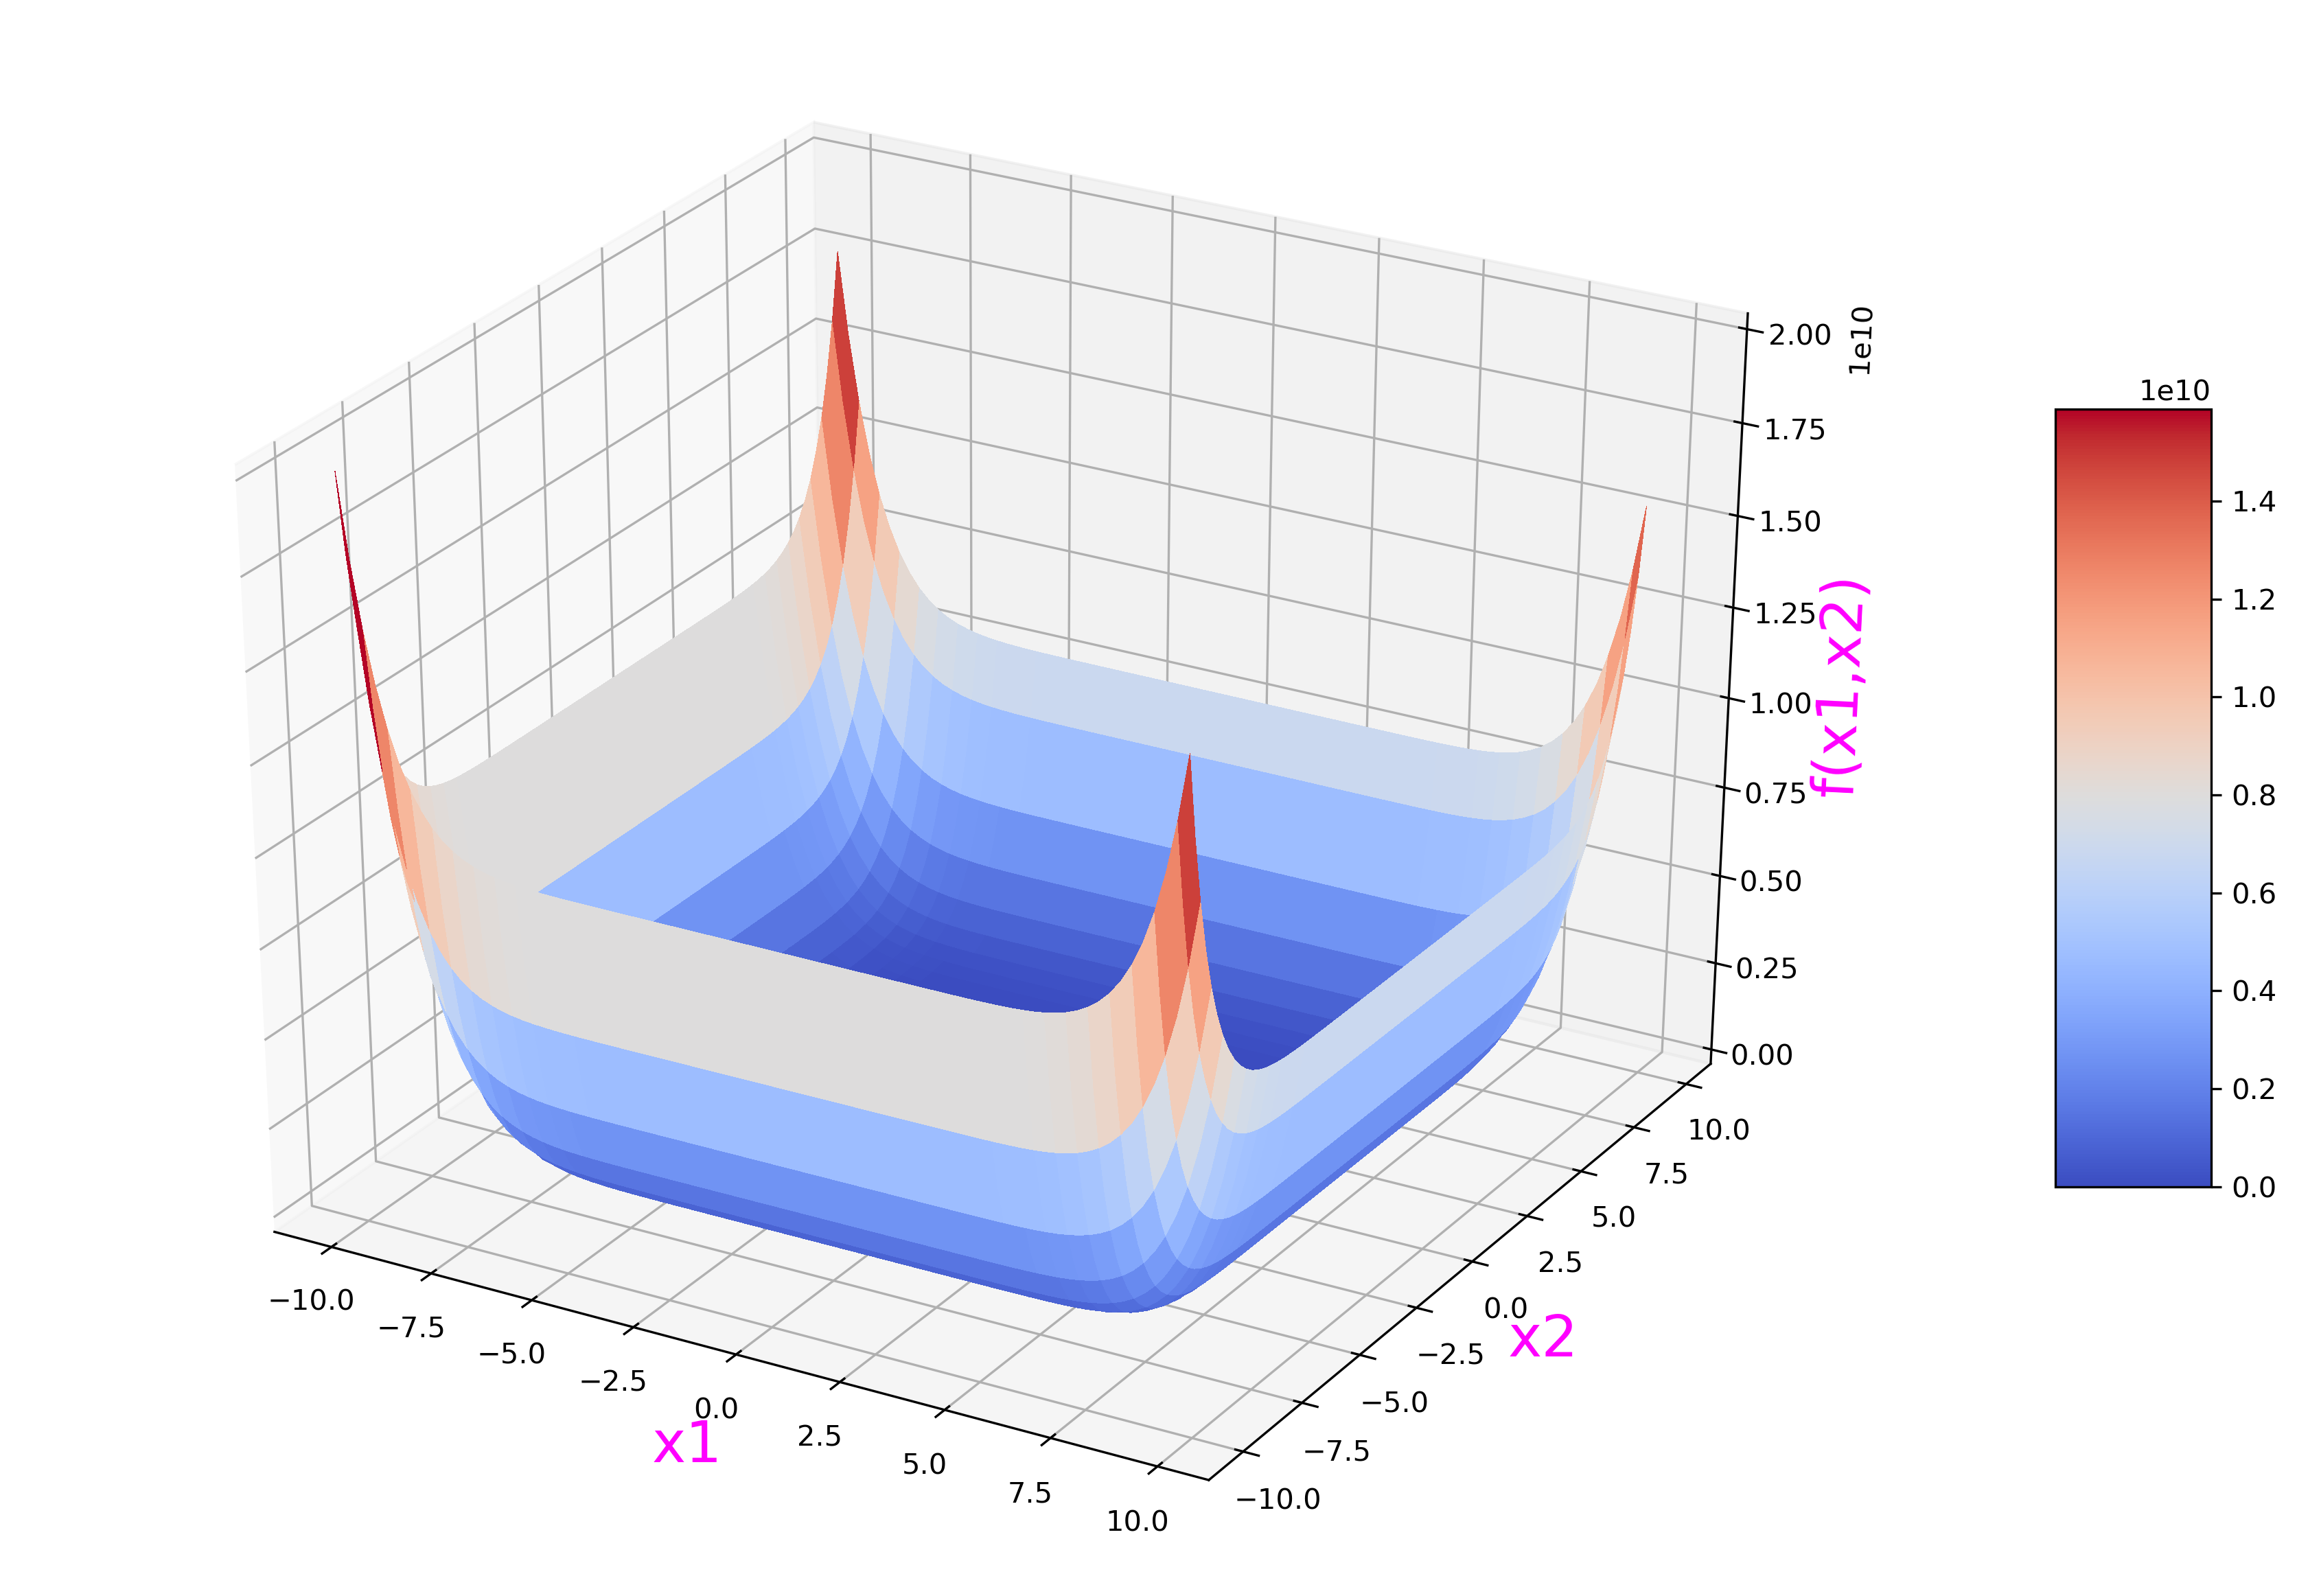

In [52]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure(figsize=(15, 10), dpi=300)
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-10, 10, 0.25)
Y = np.arange(-10, 10, 0.25)
X, Y = np.meshgrid(X, Y)
Z = X**10 + Y**10

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('x1', fontsize=20)
ax.set_ylabel('x2', fontsize=20)
ax.set_zlabel('f(x1,x2)', fontsize=20)

ax.xaxis.label.set_color('magenta')
ax.yaxis.label.set_color('magenta')
ax.zaxis.label.set_color('magenta')

plt.show()

Η συνάρτηση για $D = 2$ έχει το σχήμα λεκάνης, με το κέντρο της να είναι στο ολικό ελάχιστο που αναφέραμε προηγουμένως. Παρατηρούμε ότι στα άκρα της εμφανίζει γωνίες που αποτελούν και τα ολικά της μέγιστα. Ασυνέχειες δεν υπάρχουν ενώ γενικά πρόκεται για συμμετρική συνάρτηση.

Για να βρούμε το βέλτιστο συνδυασμό ακολουθούμε την ίδια διαδικασία με προηγουμένως.

In [90]:
F_MIN = -10
F_MAX = 10

def Schwefel_2_23(x):
    return sum(xi**10 for xi in x),

def feasible2(x):
    return all(F_MIN <= i <= F_MAX for i in x)

def distance2(x):
    dist = 0
    for xi in x:
        dist += max(0, xi - F_MAX)
        dist += max(0, F_MIN - xi)
    return dist

In [91]:
tbox = base.Toolbox()
setbox(tbox, Schwefel_2_23, feasible2, distance2, fmin=-10, fmax=10)

In [19]:
res_nodelta2 = combination_search(tbox)

In [20]:
sort_print(res_nodelta2)

operators,strategy,avg.min,avg.evals,avg.time
"UniformCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentLow",Simple,0,2.26844e+07,0.416764
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentLow",Simple,0,2.15059e+07,0.419641
"UniformCrossoverHigh, GaussianMutationLow, SelectionTournamentLow",Simple,0,2.12938e+07,0.427668
"UniformCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,1.83465e+07,0.478941
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.82148e+07,0.482681
"UniformCrossoverHigh, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.92321e+07,0.484041
"BlendCrossoverHigh, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.93199e+07,0.485154
"UniformCrossoverHigh, GaussianMutationHigh, SelectionTournamentHigh",Simple,0,1.9606e+07,0.49052
"UniformCrossoverLow, mutShuffleIndexesLow, SelectionTournamentLow",Plus,0,2.2103e+07,0.546281
"UniformCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentLow",Comma,0,1.9447e+07,0.547449


Παρατηρούμε ακρίβεια μέχρι και 300 δεκαδικών ψηφίων στα καλύτερα ελάχιστα, οπότε θέτουμε αντίστοιχο **Δέλτα**.

In [ ]:
res_delta2 = combination_search(tbox, DELTA=10**(-300))

In [50]:
sort_print(res_delta2, succ = True, succ_avg_evals = True, succ_avg_min=True, succ_avg_gen=True)

operators,strategy,avg.min,avg.evals,avg.time,successes,success avg.gen,success avg.min,success avg.evals
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.99295e+07,0.481741,10,2.7,0,1.43472e+09
"UniformCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,1.98535e+07,0.480001,10,2.8,0,1.59607e+09
"UniformCrossoverLow, mutShuffleIndexesLow, SelectionTournamentHigh",Simple,0,1.9023e+07,0.479416,10,2.9,0,1.13191e+09
"UniformCrossoverLow, mutShuffleIndexesLow, SelectionTournamentLow",Simple,0,2.11043e+07,0.417572,10,3,0,1.60593e+09
"UniformCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentLow",Simple,0,2.12204e+07,0.417097,10,3.6,0,1.42529e+09
"UniformCrossoverLow, mutShuffleIndexesLow, SelectionTournamentHigh",Plus,0,2.03495e+07,0.272337,10,3.8,0,1.51051e+09
"UniformCrossoverHigh, mutShuffleIndexesHigh, SelectionTournamentLow",Simple,0,1.92881e+07,0.419294,10,3.9,0,1.30469e+09
"UniformCrossoverHigh, mutShuffleIndexesHigh, SelectionTournamentHigh",Plus,0,1.94023e+07,0.275975,10,4.4,0,1.08704e+09
"UniformCrossoverHigh, mutShuffleIndexesLow, SelectionTournamentHigh",Plus,0,1.90542e+07,0.275593,10,5,0,7.8497e+08
"UniformCrossoverHigh, mutShuffleIndexesHigh, SelectionTournamentLow",Comma,0,1.80058e+07,0.258136,10,5.2,0,6.35358e+08


Ο καλύτερος, λοιπόν, συνδυασμός είναι ο **Uniform Low**, **Shuffle High**, **Selection High** και **απλός** αλγόριθμος.

In [55]:
best_ops2 = [mate_['UniLow'],mutate_['ShufHigh'],select_['High']]
best_alg2 = alg_['Simple']

In [59]:
interval1 = np.arange(0.05, 1.0, 0.05)
interval2 = np.arange(0.05, 1.0, 0.05)
res_probs2 = prob_search(tbox, best_ops2, best_alg2,interval1,interval2, DELTA=10**(-300))

In [60]:
sort_print(res_probs2, probs=True, succ = True, succ_avg_evals = True, succ_avg_min=True, succ_avg_gen=True)

operators,strategy,avg.min,avg.evals,avg.time,successes,success avg.gen,success avg.min,success avg.evals,cxpb,mutpb
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.74294e+07,0.533942,10,1.7,0,1.91588e+09,0.7,0.6
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.95368e+07,0.540664,10,1.9,0,2.05001e+09,0.65,0.75
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.87777e+07,0.520102,10,2,0,1.79378e+09,0.8,0.35
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,2.03822e+07,0.52513,10,2,0,1.93485e+09,0.9,0.35
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.86989e+07,0.530487,10,2,0,1.70774e+09,0.8,0.45
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.9008e+07,0.532396,10,2,0,1.84766e+09,0.9,0.5
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.79463e+07,0.543337,10,2,0,1.74113e+09,0.65,0.65
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.9209e+07,0.545785,10,2,0,1.81977e+09,0.9,0.7
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.93045e+07,0.50343,10,2.1,0,1.77158e+09,0.25,0.5
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.73511e+07,0.51232,10,2.1,0,1.49448e+09,0.6,0.4


Βέλτιστες, λοιπόν, πιθανότητες οι 0.7 και 0.6 για διασταύρωση και μετάλλαξη αντίστοιχα.
Εκτελούμε ακόμα μία φορά για μεγαλύτερη ακρίβεια, όπως προηγουμένως.

In [62]:
interval1 = np.arange(0.66, 0.75, 0.01)
interval2 = np.arange(0.56, 0.65, 0.01)
res_probs2_prec = prob_search(tbox, best_ops2, best_alg2,interval1,interval2, DELTA=10**(-300))

In [64]:
sort_print(res_probs2_prec,probs=True, succ = True, succ_avg_evals = True, succ_avg_min=True, succ_avg_gen=True)

operators,strategy,avg.min,avg.evals,avg.time,successes,success avg.gen,success avg.min,success avg.evals,cxpb,mutpb
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.84789e+07,0.531643,10,1.8,0,1.90397e+09,0.69,0.59
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.84031e+07,0.532353,10,1.8,0,2.00392e+09,0.69,0.6
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.83956e+07,0.526237,10,2.1,0,1.70383e+09,0.69,0.56
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.96823e+07,0.530906,10,2.2,0,1.90291e+09,0.66,0.61
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.92655e+07,0.535056,10,2.2,0,2.00661e+09,0.73,0.63
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.82714e+07,0.535094,10,2.2,0,1.67425e+09,0.7,0.64
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.88856e+07,0.535705,10,2.2,0,1.501e+09,0.66,0.57
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,2.03762e+07,0.532333,10,2.4,0,1.65997e+09,0.72,0.6
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,2.05573e+07,0.532803,10,2.4,0,1.65681e+09,0.73,0.59
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.78599e+07,0.533242,10,2.4,0,1.22155e+09,0.68,0.62


Τέλος, για το βέλτιστο συνδυασμό και πιθανότητες 0.69 και 0.59 ελαχιστοποιούμε ακόμα μία φορά τη συνάρτηση.

In [66]:
final_part2 = [compute(tbox, best_ops2, best_alg2, DELTA=10**(-300), cxpb=0.69, mutpb=0.59,
                      max_rounds=20, max_gens=300, population=200)]

In [67]:
sort_print(final_part2, evals=False, min_=False, succ = True, succ_avg_gen = True, succ_avg_min=True)

operators,strategy,avg.time,successes,success avg.gen,success avg.min
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,2.12522,20,2.15,0


# D = 1, 10, 20, 40, >=40

Θέτουμε τον καλύτερο συνδυασμό σε νέες μεταβλητές για δική μας ευκολία.

In [92]:
op, alg, cx, mut = [mate_['UniLow'],mutate_['ShufHigh'],select_['High']], alg_['Simple'], 0.69, 0.59, # Best combination and probabilities here

Η συνάρτηση `dim_analyze` τρέχει με τον ίδιο τρόπο τον αλγόριθμο, αλλάζοντας όμως τον αριθμό των διαστάσεων και την αντίστοιχη ποινή. Ως όρισμα λαμβάνει μία λίστα από τις επιθυμητές διαστάσεις και μια λίστα από τις αντίστοιχες ποινές, τις οποίες και εμφανίζει στον πίνακα.

In [195]:
def dim_analyze(toolbox, dims, pens, max_rounds=10, max_gens=150, population=100, DELTA=10**(-300), fmin=-10, fmax=10):
    result = []
    for dim, pen in zip(dims, pens):
        setbox(tbox,evalfunc=Schwefel_2_23, feasible = feasible2, distance=distance2, fmin=fmin, fmax=fmax, fdim=dim, penalty=pen)
        result += [compute(tbox, op, alg, cxpb=cx, mutpb=mut, DELTA=DELTA, max_gens=max_gens, max_rounds=max_rounds, population=population, mu=population, lambda_=population)]
    return result

In [148]:
def part2(res):
    sort_print(res, min_=True, evals = False, probs=False, succ=True, 
           succ_avg_min=True, succ_avg_gen=True, succ_avg_evals=False, dim=True)

Εκτελούμε τη συνάρτηση, λοιπόν, με κλιμακώμενες διαστάσεις και ποινές:

In [151]:
dims=[10,20,30,40,50]
pens=[10**(2*i) for i in range(2,7)]

In [155]:
res_dim = dim_analyze(tbox, dims=dims,pens=pens,DELTA=10**(-300))

In [160]:
part2(res_dim)

operators,strategy,avg.min,avg.time,successes,success avg.gen,success avg.min,Dimension,Penalty
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,0.781839,10,16.2,0,10,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.09741,10,26.3,0,20,1000000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,2.0242,10,48.6,0,50,1000000000000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,3,1.40085,9,33.8889,0,30,100000000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,4,1.72586,9,41.8889,0,40,10000000000


Παρατηρούμε ότι δεν είναι εγγυημένο το σωστό αποτέλεσμα καθώς δεν σημειώνεται για κάθε διάσταση πλήρης επιτυχία. Ως αποτέλεσμα, ο ολικός μέσος όρος, αν τρέχαμε τους αλγορίθμους για σταθερό αριθμό γενεών, δεν είναι πάντα 0, αλλά αρκετά παραπάνω.

Επιπλέον, παρατηρούμε ότι όσο αυξάνουν οι διαστάσεις αυξάνει και ο απαιτούμενος αριθμός γενεών προκειμένου να σημειωθεί επιτυχία. Αυτό οφείλεται στο ότι όσο αυξάνεται το μέγεθος του διανύσματος εισόδου της συνάρτησης μειώνεται η πιθανότητα να βρίσκουμε συνδυασμό D τιμών που να δίνουν όλο και μικρότερη τιμή σε κάθε επόμενη γενιά. 

Για την συνάρτησή μας το γεγονός ότι οι όλες οι μεταβλητές μπορούν να αρχικοποιθούν κοντά στα $|x_i|=10$, στα οποία η τιμή της συνάρτησης απειρίζεται όσο μεγαλώνει η διάσταση, σημαίνει ότι ο αλγόριθμος μπορεί να μην προλαβαίνει να μειώσει τις τιμές μέσα στο δοσμένο αριθμό γενεών. Επομένως, μία λύση θα ήταν να μειώνουμε το διάστημα αρχικοποίησης για να μειώσουμε τη πιθανότητα να συμβεί. Εργαζόμαστε για διάσταση 40 και έχουμε:

In [202]:
dims=[40 for i in range(10)]
pens=[10**(4) for i in range(10)]

Για διάστημα αρχικοποίησης [-10,10]:

In [209]:
res_dim = dim_analyze(tbox, dims=dims,pens=pens,DELTA=10**(-300), fmin=-10,fmax=10)
part2(res_dim)

operators,strategy,avg.min,avg.time,successes,success avg.gen,success avg.min,Dimension,Penalty
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.71952,10,41.3,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.71723,10,41.8,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.7206,10,42.5,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.71882,10,42.9,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.64964,10,45.4,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.72136,10,45.9,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.72304,10,47.2,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,4,1.72347,9,41.2222,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,4,1.72323,9,42.1111,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,4,1.7231,9,42.6667,0,40,10000


Για διάστημα αρχικοποίησης [-9,9]:

In [204]:
res_dim = dim_analyze(tbox, dims=dims,pens=pens,DELTA=10**(-300), fmin=-9,fmax=9)
part2(res_dim)

operators,strategy,avg.min,avg.time,successes,success avg.gen,success avg.min,Dimension,Penalty
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.71907,10,39.1,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.71517,10,39.3,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.72139,10,39.7,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.71891,10,40.5,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.61832,10,42,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.71349,10,42.2,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.71579,10,43.3,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,4,1.71853,9,40.8889,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,4,1.7213,9,41.8889,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,4,1.71321,9,43.2222,0,40,10000


Για διάστημα αρχικοποίησης [-8,8]:

In [206]:
res_dim = dim_analyze(tbox, dims=dims,pens=pens,DELTA=10**(-300), fmin=-8,fmax=8)
part2(res_dim)

operators,strategy,avg.min,avg.time,successes,success avg.gen,success avg.min,Dimension,Penalty
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.73381,10,37.3,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.73675,10,37.5,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.72693,10,38.1,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.73028,10,38.3,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.73968,10,38.8,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.72077,10,39.5,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.68636,10,39.9,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.73414,10,40,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.7545,10,40.6,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.73207,10,43,0,40,10000


Για διάστημα αρχικοποίησης [-7,7]:

In [207]:
res_dim = dim_analyze(tbox, dims=dims,pens=pens,DELTA=10**(-300), fmin=-7,fmax=7)
part2(res_dim)

operators,strategy,avg.min,avg.time,successes,success avg.gen,success avg.min,Dimension,Penalty
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.73614,10,33.6,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.73936,10,34.6,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.59125,10,35.9,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.72953,10,36.2,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.75151,10,36.2,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.73467,10,36.3,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.73926,10,37.2,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.72155,10,37.8,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.75032,10,37.8,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.73121,10,38,0,40,10000


Για διάστημα αρχικοποίησης [-6,6]:

In [208]:
res_dim = dim_analyze(tbox, dims=dims,pens=pens,DELTA=10**(-300), fmin=-6,fmax=6)
part2(res_dim)

operators,strategy,avg.min,avg.time,successes,success avg.gen,success avg.min,Dimension,Penalty
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.72402,10,32.6,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.72304,10,32.7,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.66915,10,34,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.71536,10,34.1,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.7163,10,34.1,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.74053,10,34.1,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.72631,10,34.2,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.7147,10,34.5,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.7183,10,36.2,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.71974,10,37,0,40,10000


Για διάστημα αρχικοποίησης [-5,5]:

In [211]:
res_dim = dim_analyze(tbox, dims=dims,pens=pens,DELTA=10**(-300), fmin=-5,fmax=5)
part2(res_dim)

operators,strategy,avg.min,avg.time,successes,success avg.gen,success avg.min,Dimension,Penalty
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.59116,10,29.9,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.71968,10,30,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.72521,10,30.4,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.72702,10,30.6,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.72294,10,30.7,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.72669,10,30.9,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.7267,10,30.9,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.72602,10,31.6,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.72509,10,32.3,0,40,10000
"UniformCrossoverLow, mutShuffleIndexesHigh, SelectionTournamentHigh",Simple,0,1.73258,10,32.6,0,40,10000


Παρατηρούμε ότι πράγματι σε μικρότερο διάστημα αρχικοποίησης είχαμε πλήρεις επιτυχίες σε κάθε μία εκτέλεση του αλγορίθμου, ενώ ταυτόχρονα παρατηρήσαμε ότι το πλήθος των γενεών που απαιτήθηκε ώστε να σημειωθεί επιτυχία μειονώταν.